In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import collections
import copy

In [2]:
def gen_data(n, d, w, gamma, p):
    ys = torch.distributions.Bernoulli(torch.tensor(p)).sample((n, 1))
    scaleDown = torch.tensor([1., 1.])
    zs = torch.randn(n, d)
    xs = (zs) / scaleDown[ys.long()] + gamma * (2*ys-1) * w
    return xs.float(), ys

In [3]:
def bayes_accuracy(xs, ys, w, gamma, p):
    ''' Only for symmetric data '''
    temp = 1/(1+torch.exp(2*gamma*torch.matmul(xs, w)))
    preds = temp <= p
    return (preds == ys[:,0]).float().mean()

In [4]:
# plot the decision boundary of the linear neural network on the source dataset
def plot_decision_boundary2(model, title, ax, alpha=1):
    x = np.linspace(-5, 5, 100)
    y = -model[0].bias.data.item()/model[0].weight.data[0,1].item() - model[0].weight.data[0,0].item()/model[0].weight.data[0,1].item() * x
    ax.plot(x, y, label=title, alpha=alpha, c='orange')

In [5]:
def train_on_source(xTrain, yTrain, xTest, yTest):
    '''
    Trains a logistic regression model on the source dataset and returns the model.
    '''
    model = nn.Sequential(nn.Linear(xTrain.shape[1], 1))
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    for i in tqdm(range(10000)):
        optimizer.zero_grad()
        outputs = torch.sigmoid(model(xTrain))
        loss = F.binary_cross_entropy(outputs, yTrain)
        loss.backward()
        optimizer.step()
    return model

In [14]:
def adapt(model, xTarget, epochs = 10000, threshold = 0.):
    '''
    Adapts the model to the target dataset and returns the adapted model.
    Current code uses Adam since the SGD was very slow.
    '''
    models = []
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    for i in tqdm(range(epochs)):
        optimizer.zero_grad()
        outputs = model(xTarget)
        
        probsPred = torch.sigmoid(outputs)
        labelPreds = (probsPred > 0.5).float().detach()
        # idx = (probsPred > threshold) | (probsPred < 1-threshold)
        # loss = F.binary_cross_entropy(probsPred[idx], labelPreds[idx])
        
        loss = F.binary_cross_entropy(probsPred, labelPreds)

        # labelPreds = (outputs > 0).float().detach()
        # loss = torch.mean(torch.clamp(1 - outputs.t() * labelPreds, min=0))
        # loss = torch.mean(torch.exp(-outputs.t() * labelPreds))
        loss.backward()    
        optimizer.step()
        # with torch.no_grad():
        #     model[0].weight /= torch.norm(model[0].weight)
        #     model[0].bias /= torch.norm(model[0].weight)
        if i % 100 == 0:
            models.append(copy.deepcopy(model))
    return models

In [7]:
def grad_by_data_on_model(model, xs):
    model.zero_grad()
    probPred = torch.sigmoid(model(xs))
    labelPred = (probPred > 0.5).float().detach()
    loss = F.binary_cross_entropy(probPred, labelPred)
    loss.backward()
    return model[0].weight.grad.data.clone(), model[0].bias.grad.data.clone()

In [8]:
def evaluate(model, x, y):
    return((model(x) > 0) == y).float().mean().item()

In [9]:
n = 2000
d = 2
w = torch.ones(d)/np.sqrt(d)
gamma = 1
pSource = 0.5
pTarget = 0.5

In [15]:
xSourceTrain, ySourceTrain = gen_data(n, d, w, gamma, pSource)
xSourceTest, ySourceTest = gen_data(n, d, w, gamma, pSource)

xTargetTrain, yTargetTrain = gen_data(n, d, w, gamma, pTarget)
xTargetTest, yTargetTest = gen_data(n, d, w, gamma, pTarget)

In [16]:
# initialize a linear model whose classifier is the line parallel to y+x=0 and passes through [1/sqrt(2), 1/sqrt(2)]
model = nn.Sequential(nn.Linear(2, 1))
model[0].weight.data = torch.tensor([[1., 1.]]).float()
model[0].bias.data = torch.tensor(torch.sum(torch.mean(xSourceTrain[ySourceTrain[:,0] == 1], dim=0))).float()


/var/folders/_x/wtryhxsj37vd8b_d3pb8klt40000gn/T/ipykernel_31859/2995728861.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model[0].bias.data = torch.tensor(torch.sum(torch.mean(xSourceTrain[ySourceTrain[:,0] == 1], dim=0))).float()


In [17]:
adaptedModel = copy.deepcopy(model)
adaptedModels = adapt(adaptedModel, xTargetTrain, epochs=500000)

100%|██████████| 500000/500000 [03:16<00:00, 2539.62it/s]


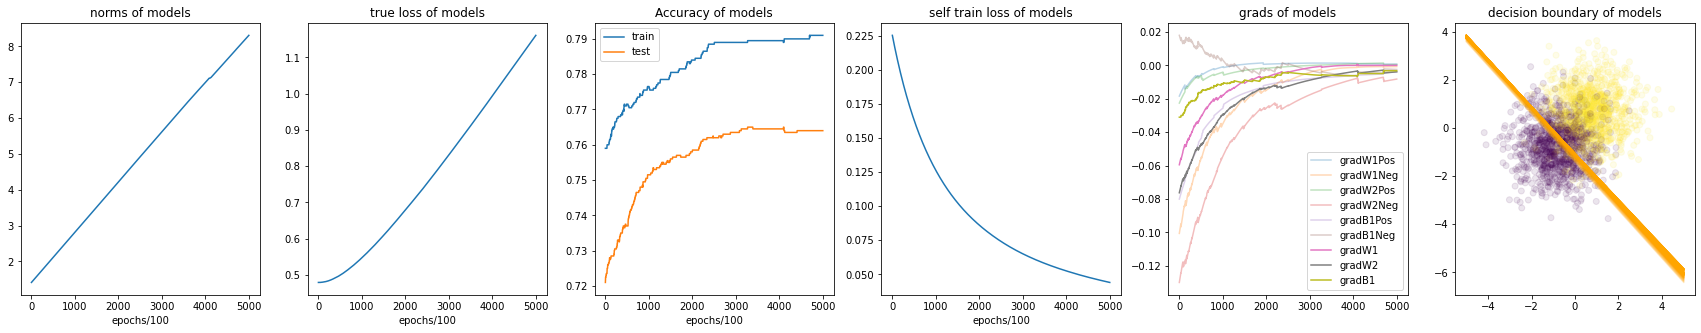

In [18]:
f, ax = plt.subplots(1, 6, figsize=(30, 5))
normsOfModels = [torch.norm(model[0].weight.data).item() for model in adaptedModels]
trueLossOfModels = [F.binary_cross_entropy_with_logits(model(xTargetTrain), yTargetTrain).detach() for model in adaptedModels]
trainAccuracyOfModels = [evaluate(model, xTargetTrain, yTargetTrain) for model in adaptedModels]
testAccuracyOfModels = [evaluate(model, xTargetTest, yTargetTest) for model in adaptedModels]
gradsW1Pos = []
gradsW1Neg = []
gradsW2Pos = []
gradsW2Neg = []
gradsB1Pos = []
gradsB1Neg = []
for model in adaptedModels:
    gradW1Pos, gradB1Pos = grad_by_data_on_model(model, xTargetTrain[yTargetTrain[:,0] == 1])
    gradW1Neg, gradB1Neg = grad_by_data_on_model(model, xTargetTrain[yTargetTrain[:,0] == 0])
    gradsW1Pos.append(gradW1Pos[0,0].item())
    gradsW1Neg.append(gradW1Neg[0,0].item())
    gradsW2Pos.append(gradW1Pos[0,1].item())
    gradsW2Neg.append(gradW1Neg[0,1].item())
    gradsB1Pos.append(gradB1Pos.item())
    gradsB1Neg.append(gradB1Neg.item())
    



selfTrainLossOfModels = []
for model in adaptedModels:
    probPred = torch.sigmoid(model(xTargetTrain))
    labelPred = (probPred > 0.5).float()
    selfTrainLossOfModels.append(F.binary_cross_entropy(probPred, labelPred).detach())

ax[0].plot(normsOfModels)
ax[0].set_title('norms of models')
ax[0].set_xlabel('epochs/100')
ax[1].plot(trueLossOfModels)
ax[1].set_title('true loss of models')
ax[1].set_xlabel('epochs/100')
ax[2].plot(trainAccuracyOfModels)
ax[2].plot(testAccuracyOfModels)
ax[2].set_title('Accuracy of models')
ax[2].legend(['train', 'test'])
ax[2].set_xlabel('epochs/100')
ax[3].plot(selfTrainLossOfModels)
ax[3].set_title('self train loss of models')
ax[3].set_xlabel('epochs/100')
ax[4].plot(gradsW1Pos, alpha=0.3)
ax[4].plot(gradsW1Neg, alpha=0.3)
ax[4].plot(gradsW2Pos, alpha=0.3)
ax[4].plot(gradsW2Neg, alpha=0.3)
ax[4].plot(gradsB1Pos, alpha=0.3)
ax[4].plot(gradsB1Neg, alpha=0.3)
ax[4].plot((np.array(gradsW1Pos) + np.array(gradsW1Neg))/2, alpha=1)
ax[4].plot((np.array(gradsW2Pos) + np.array(gradsW2Neg))/2, alpha=1)
ax[4].plot((np.array(gradsB1Pos) + np.array(gradsB1Neg))/2, alpha=1)
ax[4].set_title('grads of models')
ax[4].legend(['gradW1Pos', 'gradW1Neg', 'gradW2Pos', 'gradW2Neg', 'gradB1Pos', 'gradB1Neg', 'gradW1', 'gradW2', 'gradB1'])
for i, model in enumerate(adaptedModels):
    if i % 50 == 0:
        plot_decision_boundary2(model, str(i), ax[5], alpha=np.exp(2*(i/len(adaptedModels)-1)))
ax[5].scatter(xTargetTrain[:,0], xTargetTrain[:,1], c=yTargetTrain[:,0], alpha=0.1)
ax[5].set_title('decision boundary of models')
plt.show()

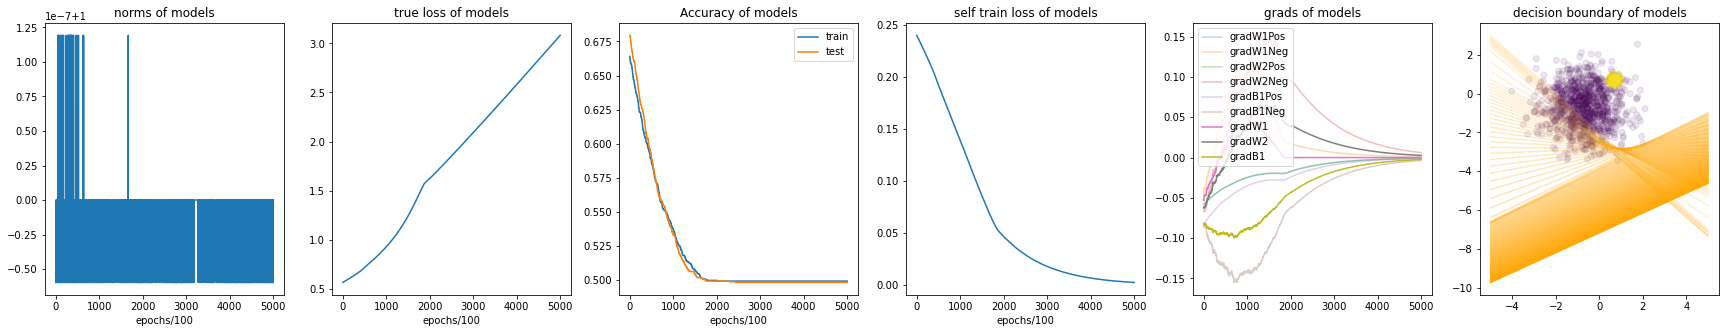

In [126]:
f, ax = plt.subplots(1, 6, figsize=(30, 5))
normsOfModels = [torch.norm(model[0].weight.data).item() for model in adaptedModels]
trueLossOfModels = [F.binary_cross_entropy_with_logits(model(xTargetTrain), yTargetTrain).detach() for model in adaptedModels]
trainAccuracyOfModels = [evaluate(model, xTargetTrain, yTargetTrain) for model in adaptedModels]
testAccuracyOfModels = [evaluate(model, xTargetTest, yTargetTest) for model in adaptedModels]
gradsW1Pos = []
gradsW1Neg = []
gradsW2Pos = []
gradsW2Neg = []
gradsB1Pos = []
gradsB1Neg = []
for model in adaptedModels:
    gradW1Pos, gradB1Pos = grad_by_data_on_model(model, xTargetTrain[yTargetTrain[:,0] == 1])
    gradW1Neg, gradB1Neg = grad_by_data_on_model(model, xTargetTrain[yTargetTrain[:,0] == 0])
    gradsW1Pos.append(gradW1Pos[0,0].item())
    gradsW1Neg.append(gradW1Neg[0,0].item())
    gradsW2Pos.append(gradW1Pos[0,1].item())
    gradsW2Neg.append(gradW1Neg[0,1].item())
    gradsB1Pos.append(gradB1Pos.item())
    gradsB1Neg.append(gradB1Neg.item())
    



selfTrainLossOfModels = []
for model in adaptedModels:
    probPred = torch.sigmoid(model(xTargetTrain))
    labelPred = (probPred > 0.5).float()
    selfTrainLossOfModels.append(F.binary_cross_entropy(probPred, labelPred).detach())

ax[0].plot(normsOfModels)
ax[0].set_title('norms of models')
ax[0].set_xlabel('epochs/100')
ax[1].plot(trueLossOfModels)
ax[1].set_title('true loss of models')
ax[1].set_xlabel('epochs/100')
ax[2].plot(trainAccuracyOfModels)
ax[2].plot(testAccuracyOfModels)
ax[2].set_title('Accuracy of models')
ax[2].legend(['train', 'test'])
ax[2].set_xlabel('epochs/100')
ax[3].plot(selfTrainLossOfModels)
ax[3].set_title('self train loss of models')
ax[3].set_xlabel('epochs/100')
ax[4].plot(gradsW1Pos, alpha=0.3)
ax[4].plot(gradsW1Neg, alpha=0.3)
ax[4].plot(gradsW2Pos, alpha=0.3)
ax[4].plot(gradsW2Neg, alpha=0.3)
ax[4].plot(gradsB1Pos, alpha=0.3)
ax[4].plot(gradsB1Neg, alpha=0.3)
ax[4].plot((np.array(gradsW1Pos) + np.array(gradsW1Neg))/2, alpha=1)
ax[4].plot((np.array(gradsW2Pos) + np.array(gradsW2Neg))/2, alpha=1)
ax[4].plot((np.array(gradsB1Pos) + np.array(gradsB1Neg))/2, alpha=1)
ax[4].set_title('grads of models')
ax[4].legend(['gradW1Pos', 'gradW1Neg', 'gradW2Pos', 'gradW2Neg', 'gradB1Pos', 'gradB1Neg', 'gradW1', 'gradW2', 'gradB1'])
for i, model in enumerate(adaptedModels):
    if i % 50 == 0:
        plot_decision_boundary2(model, str(i), ax[5], alpha=np.exp(2*(i/len(adaptedModels)-1)))
ax[5].scatter(xTargetTrain[:,0], xTargetTrain[:,1], c=yTargetTrain[:,0], alpha=0.1)
ax[5].set_title('decision boundary of models')
plt.show()

100%|██████████| 10000/10000 [00:07<00:00, 1351.77it/s]


AttributeError: 'Sequential' object has no attribute 'bias'

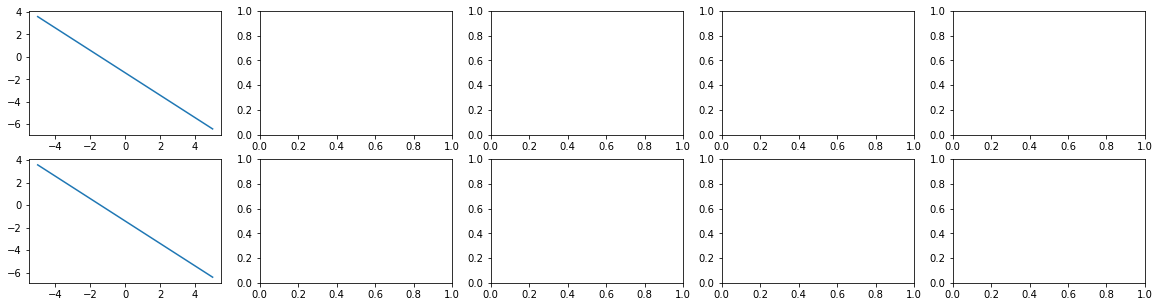

In [ ]:
f, ax = plt.subplots(2, 5, figsize=(20, 5))
init_loss = []
final_loss = []
# plot the decision boundary of the linear neural network on the source dataset before adaptation and after adaptation. Repeat 5 times
pTarget = 0.5
for i in range(1):
    xSourceTrain, ySourceTrain = gen_data(n, d, w, gamma, pSource)
    xSourceTest, ySourceTest = gen_data(n, d, w, gamma, pSource)

    xTargetTrain, yTargetTrain = gen_data(n, d, w, gamma, pTarget)
    xTargetTest, yTargetTest = gen_data(n, d, w, gamma, pTarget)
    model = nn.Sequential(nn.Linear(2, 1))
    model[0].weight.data = torch.tensor([[1., 1.]]).float()
    model[0].bias.data = torch.tensor([gamma*np.sqrt(2)]).float()
    probPred = torch.sigmoid(model(xTargetTrain))
    labelPred = (probPred > 0.5).float()
    init_loss.append(F.binary_cross_entropy(probPred, labelPred).item())

    plot_decision_boundary2(model, 'initial classifier', ax[0, i])
    plot_decision_boundary2(model, 'initial classifier', ax[1, i])
    model, norms = adapt(model, xTargetTrain, epochs=10000)
    plot_decision_boundary2(adapt(model, xTargetTrain, epochs=10000)[-1], 'adapted classifier', ax[1, i])
    probPred = torch.sigmoid(model(xTargetTrain))
    labelPred = (probPred > 0.5).float()
    final_loss.append(F.binary_cross_entropy(probPred, labelPred).item())
    ax[0, i].scatter(xSourceTrain[ySourceTrain[:,0] == 0, 0], xSourceTrain[ySourceTrain[:,0] == 0, 1], label='y=0')
    ax[0, i].scatter(xSourceTrain[ySourceTrain[:,0] == 1, 0], xSourceTrain[ySourceTrain[:,0] == 1, 1], label='y=1')
    ax[1, i].scatter(xTargetTrain[yTargetTrain[:,0] == 0, 0], xTargetTrain[yTargetTrain[:,0] == 0, 1], label='y=0')
    ax[1, i].scatter(xTargetTrain[yTargetTrain[:,0] == 1, 0], xTargetTrain[yTargetTrain[:,0] == 1, 1], label='y=1')
    ax[0, i].legend()
    ax[1, i].legend()
f.suptitle('Decision boundary of the linear neural network on the source dataset before adaptation and after adaptation for p={}, gamma={}'.format(pTarget, gamma))
plt.show()
plt.close()

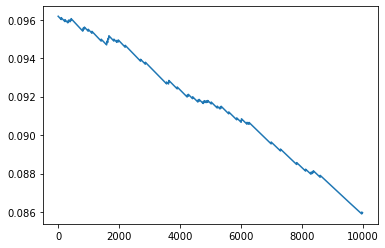

In [ ]:
plt.plot(norms)

In [ ]:
init_loss, final_loss

([0.201573446393013,
  0.19784720242023468,
  0.1982344537973404,
  0.19608843326568604,
  0.2006034404039383],
 [0.18627426028251648,
  0.18218788504600525,
  0.1826896071434021,
  0.18070928752422333,
  0.1851746141910553])

In [ ]:
model = nn.Sequential(nn.Linear(2, 1))
model[0].weight.data = torch.tensor([[1., 1.]]).float()
model[0].bias.data = torch.tensor([-gamma*np.sqrt(2)]).float()

In [ ]:
print(grad_by_data_on_model(model, xTargetTrain[yTargetTrain[:,0] == 0]))
print(grad_by_data_on_model(model, xTargetTrain[yTargetTrain[:,0] == 1]))

(tensor([[-0.0644, -0.0629]]), tensor([0.0976]))
(tensor([[-0.0241, -0.0244]]), tensor([0.0044]))


In [ ]:
for _ in range(10):
    xTargetTrain, yTargetTrain = gen_data(n, d, w, gamma, pTarget)
    model = nn.Sequential(nn.Linear(2, 1))
    model[0].weight.data = torch.tensor([[1., 1.]]).float()
    model[0].bias.data = torch.tensor([-1.5*np.sqrt(2)]).float()
    print("grad of neg labels", grad_by_data_on_model(model, xTargetTrain[yTargetTrain[:,0] == 0]))
    print("grad of pos labels", grad_by_data_on_model(model, xTargetTrain[yTargetTrain[:,0] == 1]))
    print("grad of all labels", grad_by_data_on_model(model, xTargetTrain))
    print("\n")

grad of neg labels (tensor([[-0.0076, -0.0078]]), tensor([0.0324]))
grad of pos labels (tensor([[-0.0299, -0.0308]]), tensor([-0.0043]))
grad of all labels (tensor([[-0.0190, -0.0195]]), tensor([0.0137]))


grad of neg labels (tensor([[-0.0082, -0.0083]]), tensor([0.0305]))
grad of pos labels (tensor([[-0.0293, -0.0296]]), tensor([-0.0037]))
grad of all labels (tensor([[-0.0189, -0.0191]]), tensor([0.0131]))


grad of neg labels (tensor([[-0.0096, -0.0068]]), tensor([0.0320]))
grad of pos labels (tensor([[-0.0221, -0.0231]]), tensor([0.0031]))
grad of all labels (tensor([[-0.0158, -0.0149]]), tensor([0.0176]))


grad of neg labels (tensor([[-0.0066, -0.0080]]), tensor([0.0323]))
grad of pos labels (tensor([[-0.0187, -0.0172]]), tensor([0.0074]))
grad of all labels (tensor([[-0.0126, -0.0125]]), tensor([0.0200]))


grad of neg labels (tensor([[-0.0064, -0.0086]]), tensor([0.0320]))
grad of pos labels (tensor([[-0.0238, -0.0253]]), tensor([0.0015]))
grad of all labels (tensor([[-0.0151, 

In [ ]:
bAccuSource = bayes_accuracy(xSourceTest, ySourceTest, w, gamma, pSource)
bAccuTarget = bayes_accuracy(xTargetTest, yTargetTest, w, gamma, pTarget)
print("Bayes accuracy on source is:", bAccuSource)
print("Bayes accuracy on target is:", bAccuTarget)

Bayes accuracy on source is: tensor(0.9246)
Bayes accuracy on target is: tensor(0.9234)


In [ ]:
model = train_on_source(xSourceTrain, ySourceTrain, xSourceTest, ySourceTest)
print("Accuracy on source is:", evaluate(model, xSourceTest, ySourceTest))
print("Accuracy on target is:", evaluate(model, xTargetTest, yTargetTest))

model = adapt(model, xTargetTrain)
print("Accuracy on source is:", evaluate(model, xSourceTest, ySourceTest))
print("Accuracy on target is:", evaluate(model, xTargetTest, yTargetTest))

100%|██████████| 10000/10000 [00:03<00:00, 2926.26it/s]


Accuracy on source is: 0.8349999785423279
Accuracy on target is: 0.8420000076293945


100%|██████████| 1000000/1000000 [09:19<00:00, 1787.10it/s]

Accuracy on source is: 0.7379999756813049
Accuracy on target is: 0.9210000038146973
